### Distribution of labels
In this notebook, we perform an analysis to investigate the presence and distribution of data science activities in 470 Jupyter notebooks (performing a data science task). 

In [51]:
# import libraries
import os 
from os import listdir
from os.path import isfile, join
from os.path import dirname as up

import random
import json
import numpy as np
import pandas as pd
from shutil import copyfile,copy
import itertools
from itertools import chain, combinations
from collections import Counter

from glob import glob
import scipy.stats as stats
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [52]:
# set path
path = os.getcwd()
features_path = os.path.join(path,'features','')
results_path = os.path.join(path,'results','f_label_distribution','')

if os.path.exists(results_path):
    pass
else:
    os.mkdir(results_path)

In [53]:
# load the dataset
features_df = pd.read_pickle(features_path+'f_DASWOW.pkl')
features_df.shape

(9678, 32)

In [54]:
features_df.describe()

,cell_number,execution_count,linesofcomment,linesofcode,variable_count,function_count,text/plain,image/png,text/html,execute_result,...,helper_functions,load_data,data_exploration,data_preprocessing,evaluation,modelling,prediction,result_visualization,save_results,comment_only
count,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,...,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000,9678.000000
mean,24.642591,51.903079,0.930358,6.109527,3.153544,0.147344,0.898223,0.361128,0.126059,0.507956,...,0.152511,0.095474,0.393676,0.242922,0.085968,0.182372,0.048357,0.056417,0.019012,0.022215
std,27.091784,90.876841,3.015051,12.720897,6.889012,0.728938,22.665215,9.999353,0.674014,20.332136,...,0.359534,0.293884,0.488590,0.428871,0.280332,0.386171,0.214531,0.230736,0.136575,0.147391
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,19.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,49.000000,1.000000,6.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,198.000000,650.000000,73.000000,381.000000,216.000000,28.000000,2000.000000,968.000000,22.000000,2000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
# look at the features
features_df.columns

Index(['filename', 'cell_type', 'cell_number', 'execution_count',
       'linesofcomment', 'linesofcode', 'variable_count', 'function_count',
       'text/plain', 'image/png', 'text/html', 'execute_result',
       'display_data', 'stream', 'error', 'text', 'comment',
       'code_line_before', 'code_line_after', 'markdown_heading',
       'packages_info', 'primary_label', 'helper_functions', 'load_data',
       'data_exploration', 'data_preprocessing', 'evaluation', 'modelling',
       'prediction', 'result_visualization', 'save_results', 'comment_only'],
      dtype='object')

In [56]:
# data preprocessing
#features_df.fillna(0,inplace=True)
#features_df['execution_count'].fillna(-1,inplace=True) # if no execution count is available, set it to -1

In [57]:
labels = ['comment_only', 'data_exploration',
       'data_preprocessing', 'evaluation','helper_functions', 'load_data','modelling','prediction', 
       'result_visualization', 'save_results']

In [58]:
selected = features_df.copy()
ds = selected.groupby('filename')['modelling']
print(len(set(selected['filename'].values)))

470


In [59]:
modelling_nbs = []
for key, item in ds:
    if ds.get_group(key).values.sum()>=1:
        modelling_nbs.append(key)
        
ds1 = selected[selected.filename.isin(modelling_nbs)] # modelling notebooks
ds1.index = range(ds1.shape[0])
ds1files = ds1.groupby('filename')

ds2 = selected[~selected.filename.isin(modelling_nbs)] #non-modelling notebooks
ds2.index = range(ds2.shape[0])
ds2files = ds2.groupby('filename')

In [60]:
# verify that non-modelling notebooks have atleast one of the labels: data exploration or result visualization
[key for key,item in ds2files if (ds2files.get_group(key)['data_exploration'].values.sum() + ds2files.get_group(key)['result_visualization'].values.sum()) < 1]

[]

In [61]:
### distribution of labels throughout the modelling notebooks dataset
labels_modelling = (ds1['primary_label'].value_counts()/ds1.shape[0])*100
labels_modelling

primary_label
modelling               22.931162
data_exploration        22.783124
data_preprocessing      20.118431
helper_functions         7.890452
result_visualization     6.735751
load_data                6.676536
evaluation               5.122132
prediction               3.582531
comment_only             2.176166
save_results             1.983716
Name: count, dtype: float64

In [62]:
### distribution of labels throughout the non modelling notebooks dataset
labels_nonmodelling = (ds2['primary_label'].value_counts()/ds2.shape[0])*100
labels_nonmodelling

primary_label
data_exploration        45.843312
data_preprocessing      31.303455
load_data                9.647622
helper_functions         8.039685
comment_only             2.326377
save_results             1.334246
result_visualization     1.163189
evaluation               0.342114
Name: count, dtype: float64

In [63]:
order = ['data_exploration','data_preprocessing','modelling','helper_functions',
         'load_data','evaluation','result_visualization','prediction',
         'comment_only','save_results']

In [64]:
model,value,label=[],[],[]
for o in order:
    label.append(o)
    model.append('modelling')
    try:
        value.append(labels_modelling[o])
    except:
        value.append(0)
    
for o in order:   
    label.append(o)    
    model.append('non-modelling')
    try:
        value.append(labels_nonmodelling[o])
    except:
        value.append(0)
        
dfs = pd.DataFrame(data={'type': model, 
                         'value': value,
                        'label':label})
dfs

,type,value,label
0,modelling,22.783124,data_exploration
1,modelling,20.118431,data_preprocessing
2,modelling,22.931162,modelling
3,modelling,7.890452,helper_functions
4,modelling,6.676536,load_data
5,modelling,5.122132,evaluation
6,modelling,6.735751,result_visualization
7,modelling,3.582531,prediction
8,modelling,2.176166,comment_only
9,modelling,1.983716,save_results


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


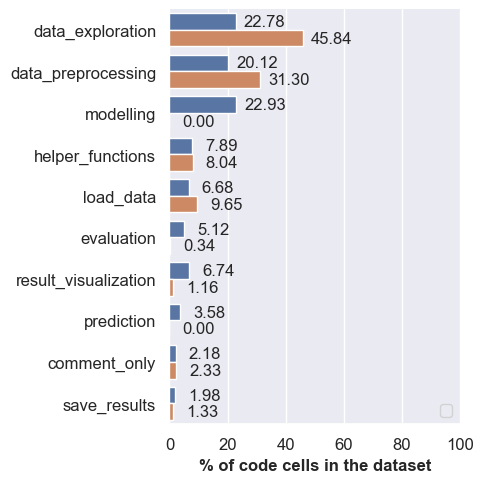

In [65]:
sns.set(rc={'figure.figsize':(9,3)})
g = sns.catplot(x = 'value', y='label', hue='type', data=dfs, kind='bar',order=order,legend=False)    
title = "distribution_of_labels_by_type_of_data_science_task"
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.2f'), 
                   (p.get_x() + p.get_width()+10,p.get_y()+.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
#ax.xaxis.grid(False)
ax.set_xlabel("% of code cells in the dataset",fontsize=12,fontweight='bold')
ax.set_ylabel("",fontsize=12,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
#axes=plt.gca()
ax.set(xlim=(0, 100))
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(results_path+title+'.eps', format='eps')

### Commonly occuring sequences

In [66]:
all_seq = []
for idx,row in selected.iterrows():
    seq = []
    for l in labels:
        if row[l]==1:
            seq.append(l)
    all_seq.append(tuple(seq))

In [67]:
top,top1,top2,top3,top4,top5 = [],[],[],[],[],[]

topsequences = Counter(all_seq).most_common()
for each in topsequences:
    top.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==1:
        if len(top1)<5:
            top1.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==2:
        if len(top2)<5:
            top2.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==3:
        if len(top3)<5:
            top3.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==4:
        if len(top4)<5:
            top4.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==5:
        if len(top5)<5:
            top5.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))

In [68]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


In [69]:
labelsets = powerset(labels)
labelsets_dict = {}
for labelset in labelsets:
    count = 0
    for seq in all_seq:
        if (all(s in list(seq) for s in labelset)):
            count += 1
    labelsets_dict[labelset] = round((count/selected.shape[0])*100,2)

In [70]:
{k: v for k, v in sorted(labelsets_dict.items(), key=lambda item: item[1], reverse=True) if len(k)==3}

{('evaluation', 'modelling', 'prediction'): 1.16,
 ('evaluation', 'helper_functions', 'modelling'): 0.85,
 ('data_exploration', 'helper_functions', 'load_data'): 0.63,
 ('helper_functions', 'modelling', 'prediction'): 0.46,
 ('evaluation', 'load_data', 'modelling'): 0.39,
 ('data_exploration', 'data_preprocessing', 'helper_functions'): 0.38,
 ('evaluation', 'helper_functions', 'prediction'): 0.38,
 ('data_exploration', 'data_preprocessing', 'load_data'): 0.33,
 ('evaluation', 'prediction', 'result_visualization'): 0.32,
 ('evaluation', 'modelling', 'result_visualization'): 0.29,
 ('modelling', 'prediction', 'result_visualization'): 0.24,
 ('data_preprocessing', 'helper_functions', 'load_data'): 0.21,
 ('load_data', 'modelling', 'prediction'): 0.19,
 ('data_exploration', 'evaluation', 'modelling'): 0.18,
 ('data_exploration', 'helper_functions', 'modelling'): 0.17,
 ('helper_functions', 'load_data', 'modelling'): 0.17,
 ('helper_functions', 'modelling', 'result_visualization'): 0.17,
 (

### Analyse the distribution of labels

In [71]:
### distribution of number of labels throughout the dataset
c = Counter(features_df[labels].sum(axis=1).values)
step_dict = pd.Series(data=c, index=c.keys())

In [72]:
### distribution of primary labels throughout the dataset
d = pd.DataFrame([dict(step_dict)]).T
d.columns = ['count']
d['step'] = d.index.astype(str)
d['percentage'] = ((step_dict/selected.shape[0])*100).values.round(2) 
d.index = range(d.shape[0])
truedistdf = d.copy()
d

,count,step,percentage
0,7368,1,76.13
1,1840,2,19.01
2,369,3,3.81
3,89,4,0.92
4,12,5,0.12


In [73]:
def plot_distribution(d,col,title,xlabel,ylabel,order):
    plt.figure(figsize=(9,3))

    ax = sns.barplot(x=col,y='step',data=d,color="skyblue")
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.2f'), 
                   (p.get_x() + p.get_width()+1.2, p.get_y()+0.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 0), 
                   textcoords = 'offset points')

    ax.xaxis.grid(False)
    ax.set_xlabel(xlabel,fontsize=12,fontweight='bold')
    ax.set_ylabel(ylabel,fontsize=12,fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(rotation=0)

    axes=plt.gca()
    plt.tight_layout()
    #plt.savefig(results_path+title+".png",dpi=300)
    plt.savefig(results_path+title+'.eps', format='eps')

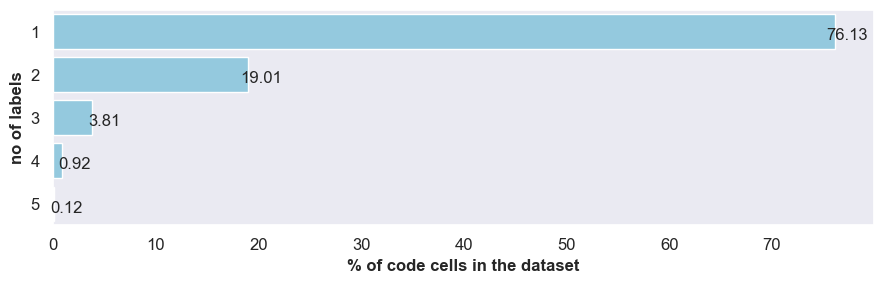

In [74]:
plot_distribution(d,'percentage',
                  "no_of_data_science_activities_in_the_dataset","% of code cells in the dataset","no of labels",
                  d.step.values)

In [75]:
import operator

def get_truth(inp, op, cut):
    return op(inp, cut)

def get_n_label_notebooks(df,labels,n,op):
    filegroup = df.groupby(['filename'])
    single_label_nbs = [k for k,v in filegroup if get_truth(max(v[labels].sum(axis=1).values),op,n)]
    
    print("No. of single label notebooks in the dateset: {0}.".format(len(single_label_nbs)),
          "% of single label notebooks in the dataset: {0:.2f}".format(len(single_label_nbs)/len(set(df.filename.values))*100))

    #### update the dataframe with notebooks that have only one labels per cell throughout
    single_label_df = df[df.filename.isin(single_label_nbs)]
    return single_label_df

In [76]:
#check that the notebooks have only one label per cell throughout
single_label_df = get_n_label_notebooks(selected,labels,1,operator.eq)
print(single_label_df.shape)

No. of single label notebooks in the dateset: 41. % of single label notebooks in the dataset: 8.72
(0, 32)


In [77]:
### distribution of primary labels throughout the dataset
step_dict = selected['primary_label'].value_counts()
d = pd.DataFrame([dict(step_dict)]).T
d.columns = ['count']
d['step'] = d.index
d['percentage'] = ((step_dict/selected.shape[0])*100).values.round(2) 
d.index = range(d.shape[0])
d

,count,step,percentage
0,2879,data_exploration,29.75
1,2274,data_preprocessing,23.50
2,1549,modelling,16.01
3,768,helper_functions,7.94
4,733,load_data,7.57
5,489,result_visualization,5.05
6,356,evaluation,3.68
7,242,prediction,2.50
8,215,comment_only,2.22
9,173,save_results,1.79


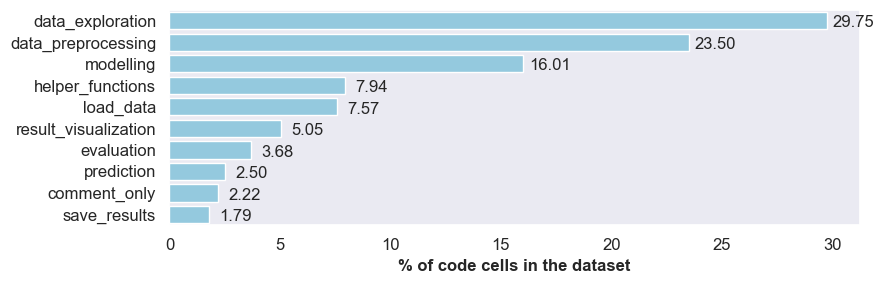

In [78]:
plot_distribution(d,'percentage',
                  "primary_label_data_science_activities_in_the_dataset",
                  "% of code cells in the dataset","",
                 step_dict.keys())

In [79]:
unsorted_multi_dict = selected[labels].sum(axis=0)
multi_dict = sorted(unsorted_multi_dict.items(), key=lambda item: item[1], reverse=True)

d = pd.DataFrame([dict(multi_dict)]).T
d.columns = ['count']
d['step'] = d.index
### distribution of labels throughout the dataset
d['percentage'] = d['count'].div(selected.shape[0]) #d['count'].sum()
d['percentage'] = d['percentage'].apply(lambda x: x*100).round(2)
d.index = range(d.shape[0])
dtrue = d.copy()
d

,count,step,percentage
0,3810,data_exploration,39.37
1,2351,data_preprocessing,24.29
2,1765,modelling,18.24
3,1476,helper_functions,15.25
4,924,load_data,9.55
5,832,evaluation,8.60
6,546,result_visualization,5.64
7,468,prediction,4.84
8,215,comment_only,2.22
9,184,save_results,1.90


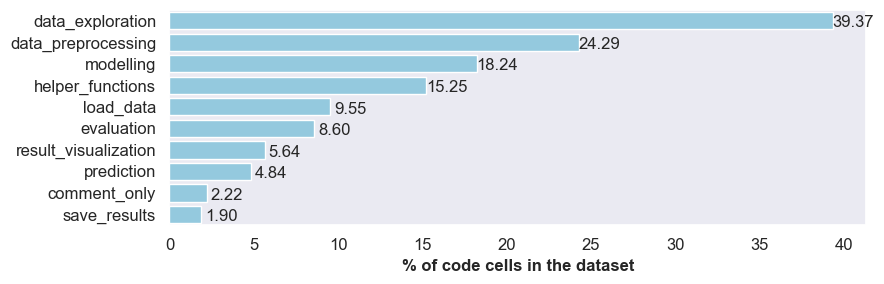

In [80]:
plot_distribution(d,'percentage',
                  "all_labels_data_science_activities_in_the_dataset",
                  "% of code cells in the dataset","",
                 step_dict.keys())

### Analyse the distribution of code and comment using primary label

In [81]:
tot_linesofcode = len(selected['text'].sum(axis=0))
tot_linesofcomments = len(selected['comment'].sum(axis=0))
print("Total lines of code: ", tot_linesofcode, " Total lines of comment: ", tot_linesofcomments)
for l in labels:
    print(l, " -> ", "linesofcode {0:.2f}".format((len(selected[selected['primary_label']==l]['text'].sum(axis=0))/tot_linesofcode)*100), "linesofcomment {0:.2f}".format((len(selected[selected['primary_label']==l]['comment'].sum(axis=0))/tot_linesofcomments)*100))

Total lines of code:  59128  Total lines of comment:  9004
comment_only  ->  linesofcode 0.10 linesofcomment 6.22
data_exploration  ->  linesofcode 19.65 linesofcomment 16.95
data_preprocessing  ->  linesofcode 24.93 linesofcomment 22.20
evaluation  ->  linesofcode 2.51 linesofcomment 2.30
helper_functions  ->  linesofcode 8.08 linesofcomment 4.18
load_data  ->  linesofcode 7.80 linesofcomment 7.51
modelling  ->  linesofcode 26.41 linesofcomment 31.46
prediction  ->  linesofcode 1.84 linesofcomment 1.63
result_visualization  ->  linesofcode 7.53 linesofcomment 6.46
save_results  ->  linesofcode 1.14 linesofcomment 1.09


In [82]:
prep_code = 0
code = 0
lines_of_code = {}
    
for idx,row in selected.iterrows():
        code += len(row['text'])
        if row['primary_label'] == 'data_exploration':
            prep_code += len(row['text'])
print(code,prep_code,prep_code/code*100)

59128 11620 19.65227979975646


### Analyse the distribution of lines of code 

In [83]:
df = features_df[features_df.cell_type=='code'].copy()
#lines of code
len(list(itertools.chain(*list(df['text'].values))))

59128

In [84]:
#lines of comment
len(list(itertools.chain(*list(df['comment'].values))))

9004

In [85]:
cell_length = []
for cell in df['text'].values:
    cell_length.append(len(cell))
c = Counter(cell_length)
loc_dict = {'0':0,'1-5':0,'6-10':0,'11-20':0,'>20':0}
for k,v in c.items():
    if k==0:
        loc_dict['0'] = loc_dict['0']+v
    elif (k>=1) and (k<=5):
        loc_dict['1-5'] = loc_dict['1-5']+v
    elif (k>=6) and (k<=10):
        loc_dict['6-10'] = loc_dict['6-10']+v
    elif (k>=11) and (k<=20):
        loc_dict['11-20'] = loc_dict['11-20']+v
    elif k>20:
        loc_dict['>20'] = loc_dict['>20']+v

In [86]:
d = pd.DataFrame([loc_dict]).T
d.columns = ['count']
d['lines of code'] = d.index
d['percentage'] = d['count']/d['count'].sum()
d['percentage'] = d['percentage'].round(2)
d.index = range(d.shape[0])

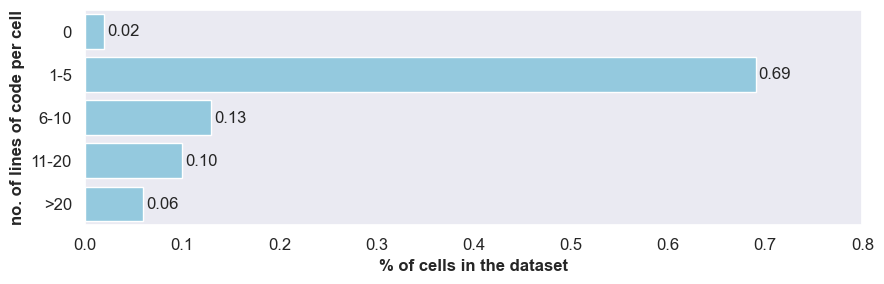

In [87]:
plt.figure(figsize=(9,3))

ax = sns.barplot(x='percentage',y='lines of code',data=d,color="skyblue",order=loc_dict.keys())
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.2f'), 
                   (p.get_x() + p.get_width()+0.02, p.get_y()+0.7), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
title = "updated no. of lines of code per cell"

ax.xaxis.grid(False)
ax.set_xlabel("% of cells in the dataset",fontsize=12,fontweight='bold')
ax.set_ylabel("no. of lines of code per cell",fontsize=12,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set(xlim=(0, 0.8))
plt.xticks(rotation=0)

axes=plt.gca()
plt.tight_layout()
plt.savefig(results_path+"codelinespercell.eps",format='eps')

### Analyse the distribution of predicted labels

In [88]:
dfpred = pd.read_pickle(os.path.join(path,'results','multi-label-classification', 'prediction_multi.pkl'))

In [89]:
unsorted_multi_dict = dfpred[labels].sum(axis=0)
multi_dict = sorted(unsorted_multi_dict.items(), key=lambda item: item[1], reverse=True)

d = pd.DataFrame([dict(multi_dict)]).T
d.columns = ['count']
d['step'] = d.index
### distribution of labels throughout the dataset
d['percentage'] = d['count'].div(dfpred.shape[0])
d['percentage'] = d['percentage'].apply(lambda x: x*100).round(2)
d.index = range(d.shape[0])
dpred = d.copy()
d

,count,step,percentage
0,788,data_exploration,41.08
1,478,data_preprocessing,24.92
2,271,modelling,14.13
3,258,helper_functions,13.45
4,143,load_data,7.46
5,70,evaluation,3.65
6,39,prediction,2.03
7,37,result_visualization,1.93
8,32,comment_only,1.67
9,19,save_results,0.99


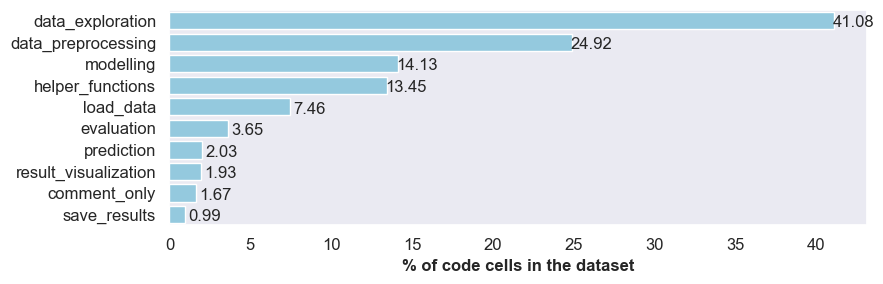

In [90]:
plot_distribution(d,'percentage',
                  "predicted_label_data_science_activities_in_the_dataset",
                  "% of code cells in the dataset","",
                 d.step.values)

In [91]:
truevals,predvals = [],[]
for l in labels:
    predvals.append(dpred[dpred['step']==l]['percentage'].values[0])
    truevals.append(dtrue[dtrue['step']==l]['percentage'].values[0])

In [92]:
from sklearn.metrics import mean_squared_error 
from scipy.stats import spearmanr,kendalltau
    
# calculate kendall's correlation
coef, p = kendalltau(truevals, predvals)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 0.956
Samples are correlated (reject H0) p=0.000


In [93]:
### distribution of number of labels throughout the dataset
c = Counter(dfpred[labels].sum(axis=1).values)
step_dict = pd.Series(data=c, index=c.keys())

### distribution of primary labels throughout the dataset
d = pd.DataFrame([dict(step_dict)]).T
d.columns = ['count']
d['step'] = d.index.astype(str)
d['percentage'] = ((step_dict/dfpred.shape[0])*100).values.round(2) 
d.index = range(d.shape[0])
preddistdf = d.copy()
d


,count,step,percentage
0,1471,1,76.69
1,277,2,14.44
2,136,0,7.09
3,28,3,1.46
4,2,5,0.10
5,4,4,0.21


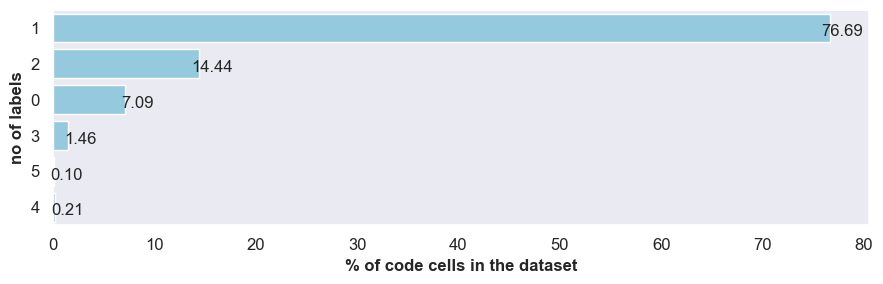

In [94]:
plot_distribution(d,'percentage',
                  "no_of_data_science_activities_in_the_predicted_dataset","% of code cells in the dataset","no of labels",
                  d.step.values)

In [95]:
truevals,predvals = [],[]
for l in [0,1,2,3,4,5]:
    try:
        truevals.append(truedistdf[truedistdf['step']==str(l)]['percentage'].values[0])
    except:
        truevals.append(0)
    try:
        predvals.append(preddistdf[preddistdf['step']==str(l)]['percentage'].values[0])
    except:
        predvals.append(0)
print(truevals)
print(predvals)
# calculate kendall's correlation
coef, p = kendalltau(truevals, predvals)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

[0, 76.13, 19.01, 3.81, 0.92, 0.12]
[7.09, 76.69, 14.44, 1.46, 0.21, 0.1]
Kendall correlation coefficient: 0.600
Samples are uncorrelated (fail to reject H0) p=0.136


In [96]:
all_seq = []
for idx,row in dfpred.iterrows():
    seq = []
    for l in labels:
        if row[l]==1:
            seq.append(l)
    all_seq.append(tuple(seq))
    
top,top1,top2,top3,top4,top5 = [],[],[],[],[],[]
topsequences = Counter(all_seq).most_common()
for each in topsequences:
    top.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==1:
        if len(top1)<5:
            top1.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==2:
        if len(top2)<5:
            top2.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==3:
        if len(top3)<5:
            top3.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==4:
        if len(top4)<5:
            top4.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
    if len(each[0])==5:
        if len(top5)<5:
            top5.append((each[0],each[1],round((each[1]/features_df.shape[0])*100,2)))
            
labelsets = powerset(labels)
labelsets_dict = {}
for labelset in labelsets:
    count = 0
    for seq in all_seq:
        if (all(s in list(seq) for s in labelset)):
            count += 1
    labelsets_dict[labelset] = round((count/selected.shape[0])*100,2)
    

In [97]:
{k: v for k, v in sorted(labelsets_dict.items(), key=lambda item: item[1], reverse=True) if len(k)==1}

{('data_exploration',): 8.14,
 ('data_preprocessing',): 4.94,
 ('modelling',): 2.8,
 ('helper_functions',): 2.67,
 ('load_data',): 1.48,
 ('evaluation',): 0.72,
 ('prediction',): 0.4,
 ('result_visualization',): 0.38,
 ('comment_only',): 0.33,
 ('save_results',): 0.2}

### Distribution of number of lines of code per label

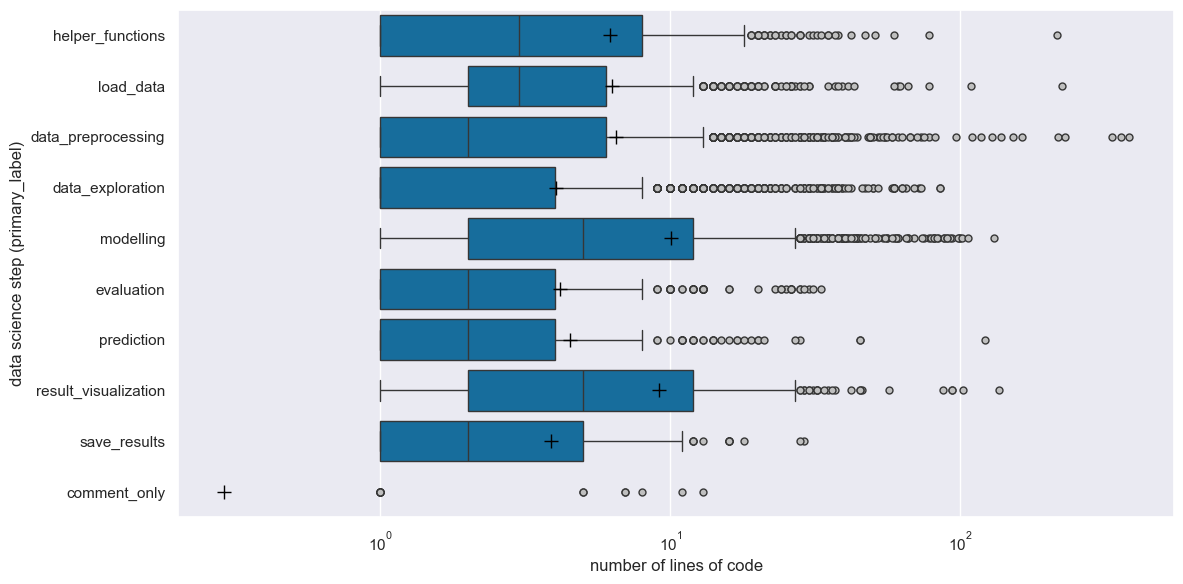

In [98]:
labels = ['helper_functions','load_data',
              'data_preprocessing','data_exploration',
              'modelling','evaluation','prediction',
              'result_visualization','save_results',
              'comment_only']

plt.figure(figsize=(12, 6))
sns.set_theme(style="ticks", palette="colorblind")

sns.set_style("darkgrid")
ax = sns.boxplot(x="linesofcode", y="primary_label", 
            showmeans=True, meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}, 
            data=features_df[features_df['cell_type']=='code'],
            showfliers=True,order=labels, 
           flierprops = dict(markerfacecolor='0.75', markersize=5,
              linestyle='none'))
#sns.despine(offset=10, trim=False)
ax.set_xscale("log")
plt.ylabel("data science step (primary_label)", size=12)
plt.xlabel("number of lines of code", size=12)
plt.tight_layout()
plt.savefig(results_path+"loc_log.eps",format='eps')